#Driven Data Simulation

##Importing Data

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mgusnadir","key":"40db2e77f61fd25fcc013458d3067587"}'}

###Set Permission for Kaggle

In [ ]:
import os
import shutil

# Move kaggle.json to the appropriate directory
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
shutil.move("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))

# Set permissions
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 600)

###Using kaggle API to download

In [ ]:
!pip install kaggle  # Ensure kaggle package is installed

# Download the dataset
!kaggle datasets download -d donovanbangs/call-centre-queue-simulation

# Unzip the dataset
!unzip call-centre-queue-simulation.zip -d call_centre_data

Dataset URL: https://www.kaggle.com/datasets/donovanbangs/call-centre-queue-simulation
License(s): CC-BY-SA-4.0
  0% 0.00/822k [00:00<?, ?B/s]
100% 822k/822k [00:00<00:00, 107MB/s]
Archive:  call-centre-queue-simulation.zip
  inflating: call_centre_data/simulated_call_centre.csv  


##Exploring Data

###Data Preview

In [ ]:
import pandas as pd

df = pd.read_csv("/content/call_centre_data/simulated_call_centre.csv")

df.info()
df.head()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51708 entries, 0 to 51707
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   call_id         51708 non-null  int64 
 1   date            51708 non-null  object
 2   daily_caller    51708 non-null  int64 
 3   call_started    51708 non-null  object
 4   call_answered   51708 non-null  object
 5   call_ended      51708 non-null  object
 6   wait_length     51708 non-null  int64 
 7   service_length  51708 non-null  int64 
 8   meets_standard  51708 non-null  bool  
dtypes: bool(1), int64(4), object(4)
memory usage: 3.2+ MB


,0
call_id,int64
date,object
daily_caller,int64
call_started,object
call_answered,object
call_ended,object
wait_length,int64
service_length,int64
meets_standard,bool


###Converting Data type

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['call_started'] = pd.to_datetime(df['call_started'], format="%I:%M:%S %p")
df['call_answered'] = pd.to_datetime(df['call_answered'], format="%I:%M:%S %p")
df['call_ended'] = pd.to_datetime(df['call_ended'], format="%I:%M:%S %p")

###Distribution of wait times and service times

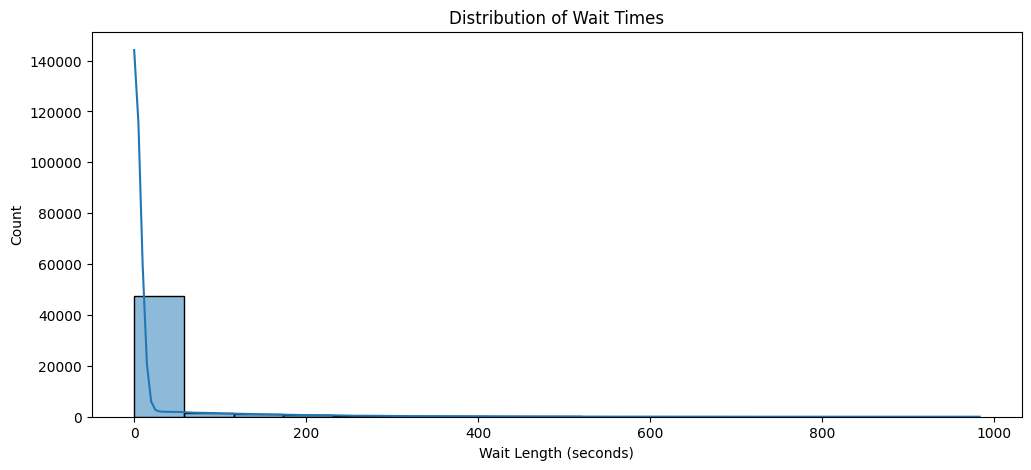

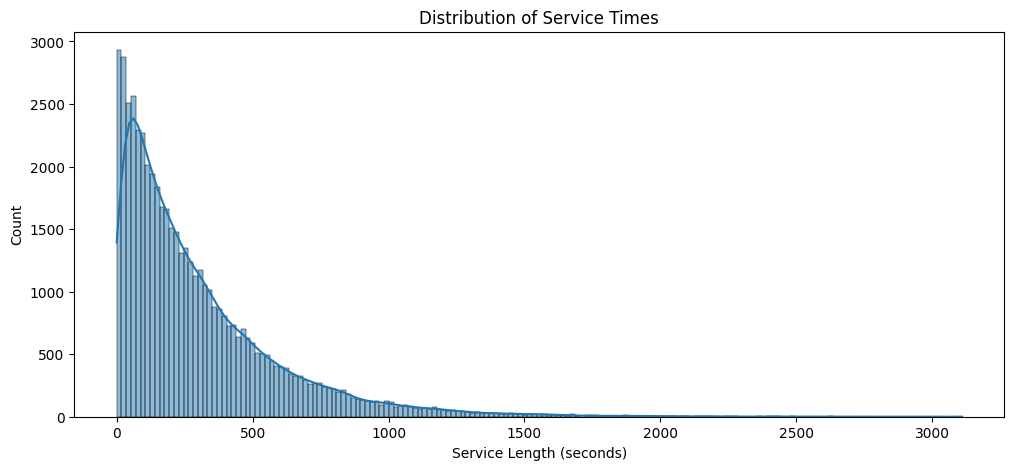

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.histplot(df['wait_length'], kde=True)
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Length (seconds)')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['service_length'], kde=True)
plt.title('Distribution of Service Times')
plt.xlabel('Service Length (seconds)')
plt.show()

###Avarage wait time per Day

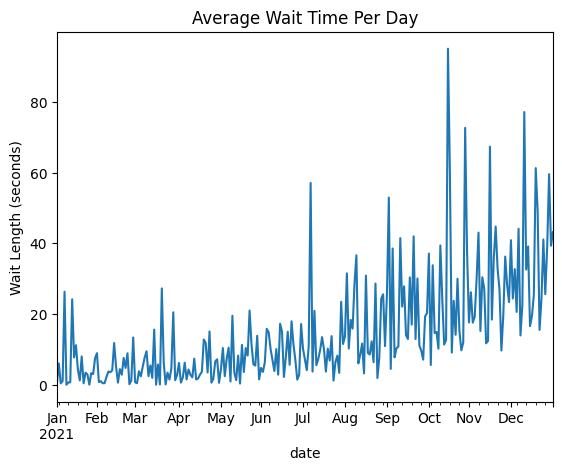

In [ ]:
df.groupby('date')['wait_length'].mean().plot(title="Average Wait Time Per Day")
plt.ylabel("Wait Length (seconds)")
plt.show()

###Calls Answered Immediately vs. Delayed

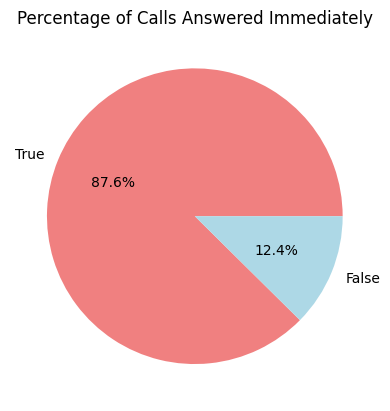

In [ ]:
df['answered_immediately'] = df['wait_length'] == 0
df['answered_immediately'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title("Percentage of Calls Answered Immediately")
plt.ylabel("")
plt.show()

##Queue Simulation

###Convert date column

In [ ]:
import numpy as np
# Reload the dataset
df = pd.read_csv("/content/call_centre_data/simulated_call_centre.csv")

# Convert date columns
df['date'] = pd.to_datetime(df['date'])
df['call_started'] = pd.to_datetime(df['call_started'], format="%I:%M:%S %p")
df['call_answered'] = pd.to_datetime(df['call_answered'], format="%I:%M:%S %p")
df['call_ended'] = pd.to_datetime(df['call_ended'], format="%I:%M:%S %p")

### Extract statistical patterns

In [ ]:
daily_calls_mean = df.groupby('date')['call_id'].count().mean()
daily_calls_std = df.groupby('date')['call_id'].count().std()
wait_time_mean = df['wait_length'].mean()
wait_time_std = df['wait_length'].std()
service_time_mean = df['service_length'].mean()
service_time_std = df['service_length'].std()

###Generate simulated data

In [ ]:
# Simulation parameters
start_date = df['date'].max() + pd.Timedelta(days=1)  # Start from the next day
num_days = 365  # Simulate for one year

# Generate simulated data
simulated_data = []
for day in range(num_days):
    current_date = start_date + pd.Timedelta(days=day)

    # Number of calls for the day (using normal distribution)
    num_calls = int(np.random.normal(daily_calls_mean, daily_calls_std))
    num_calls = max(num_calls, 1)  # Ensure at least 1 call

    for call_num in range(1, num_calls + 1):
        # Generate call times throughout the day
        call_hour = np.random.randint(8, 18)  # Calls between 8 AM - 6 PM
        call_minute = np.random.randint(0, 60)
        call_second = np.random.randint(0, 60)
        call_started = pd.Timestamp(current_date) + pd.Timedelta(hours=call_hour, minutes=call_minute, seconds=call_second)

        # Wait and service times (using normal distribution)
        wait_time = max(int(np.random.normal(wait_time_mean, wait_time_std)), 0)
        service_time = max(int(np.random.normal(service_time_mean, service_time_std)), 1)

        # Call answered and ended times
        call_answered = call_started + pd.Timedelta(seconds=wait_time)
        call_ended = call_answered + pd.Timedelta(seconds=service_time)

        # Meets standard (e.g., service time below threshold)
        meets_standard = service_time < service_time_mean + service_time_std

        # Append to list
        simulated_data.append([call_num, current_date.date(), call_num, call_started.time(),
                               call_answered.time(), call_ended.time(), wait_time, service_time, meets_standard])

# Create DataFrame
simulated_df = pd.DataFrame(simulated_data, columns=df.columns)

###Save new Simulated Data

In [ ]:
# Save to CSV
simulated_csv_path = "/content/call_centre_data/simulated_call_centre_next_year.csv"
simulated_df.to_csv(simulated_csv_path, index=False)

# Display sample of the new simulated data
simulated_df.head()

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard
0,1,2022-01-01,1,09:27:16,09:27:16,09:34:31,0,435,True
1,2,2022-01-01,2,16:50:31,16:51:35,17:07:04,64,929,False
2,3,2022-01-01,3,13:23:45,13:25:29,13:25:30,104,1,True
3,4,2022-01-01,4,12:09:07,12:09:26,12:18:35,19,549,True
4,5,2022-01-01,5,11:31:47,11:32:49,11:38:14,62,325,True


##Analyzing new simulated data

###Load the newly simulated dataset

In [ ]:
simulated_df = pd.read_csv("/content/call_centre_data/simulated_call_centre_next_year.csv")

simulated_df['date'] = pd.to_datetime(simulated_df['date'])
simulated_df['call_started'] = pd.to_datetime(simulated_df['call_started'], format="%H:%M:%S").dt.time
simulated_df['call_answered'] = pd.to_datetime(simulated_df['call_answered'], format="%H:%M:%S").dt.time
simulated_df['call_ended'] = pd.to_datetime(simulated_df['call_ended'], format="%H:%M:%S").dt.time

###Distribution of wait times and service times

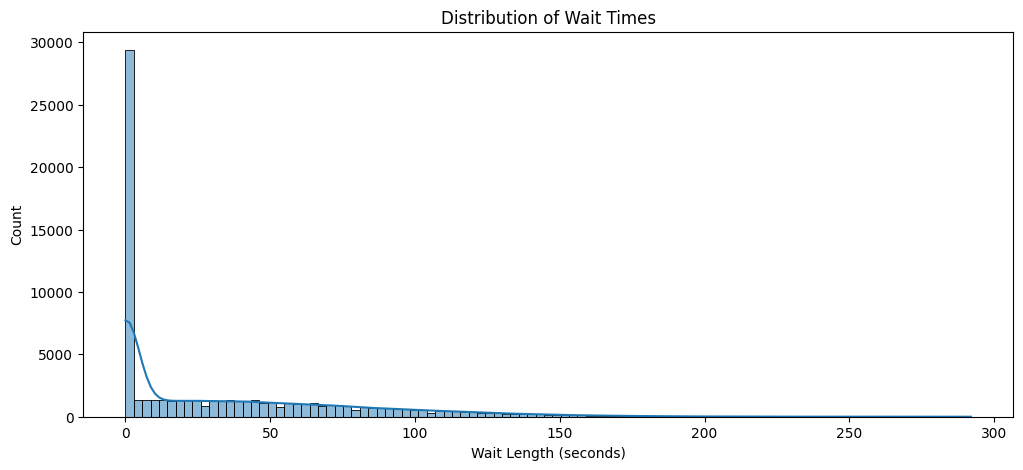

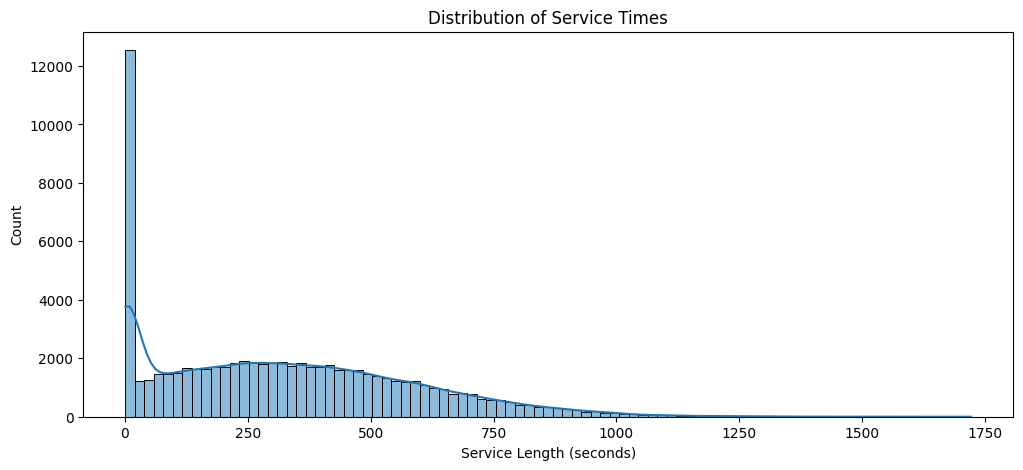

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(simulated_df['wait_length'], kde=True)
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Length (seconds)')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(simulated_df['service_length'], kde=True)
plt.title('Distribution of Service Times')
plt.xlabel('Service Length (seconds)')
plt.show()

###Avarage wait time per Day

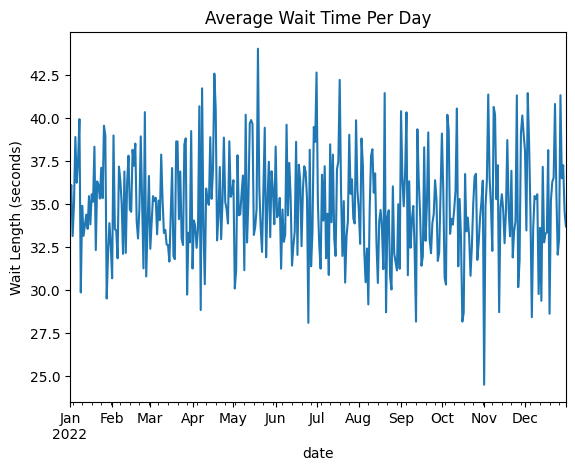

In [ ]:
simulated_df.groupby('date')['wait_length'].mean().plot(title="Average Wait Time Per Day")
plt.ylabel("Wait Length (seconds)")
plt.show()

###Percentage of Calls Answered Immediately vs. Delayed

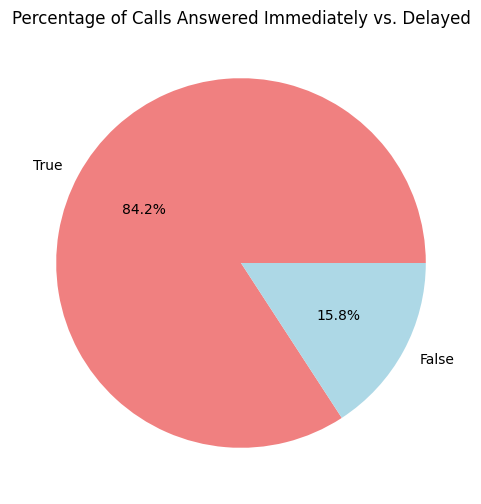

In [ ]:
plt.figure(figsize=(6,6))
simulated_df['meets_standard'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title("Percentage of Calls Answered Immediately vs. Delayed")
plt.ylabel("")
plt.show()